In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR

import lightning as L
from lightning import LightningModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wandb
from sklearn.preprocessing import StandardScaler
from torchinfo import summary


In [2]:
# Ignore
import warnings
warnings.filterwarnings("ignore")

In [3]:
lookback = 5
lookforward = 5

In [4]:
L.seed_everything(125)

Global seed set to 125


125

In [5]:
# Set multiplication level
torch.set_float32_matmul_precision('medium')

In [6]:
file_name ='all_data.gzip'
df = pd.read_parquet(file_name)
df.head()

,Type,Dataset,Year,Day,Hour,Minute,Field magnitude average nT,BX nT (GSE GSM),BY nT (GSE),BZ nT (GSE),...,Vz Velocity km/s,Proton Density n/cc,SYM/H nT,Date,month,day,time,date,B**2,BY**2
69408,Train,T1,1998,45,0,0,5.08,1.60,-4.44,-0.58,...,16.6,5.45,-12.0,1998-02-14,2,14,1998-02-14 00:00:00,1998-02-14,22.6154,12.6025
69409,Train,T1,1998,45,0,5,4.97,3.90,-1.72,1.24,...,33.5,6.04,-12.0,1998-02-14,2,14,1998-02-14 00:05:00,1998-02-14,19.7062,4.4521
69410,Train,T1,1998,45,0,10,4.91,4.01,-1.20,2.53,...,45.9,5.78,-13.0,1998-02-14,2,14,1998-02-14 00:10:00,1998-02-14,23.9443,5.3361
69411,Train,T1,1998,45,0,15,4.84,3.90,-1.29,2.48,...,41.7,5.55,-13.0,1998-02-14,2,14,1998-02-14 00:15:00,1998-02-14,23.0597,5.5696
69412,Train,T1,1998,45,0,20,4.83,4.18,-1.24,2.01,...,43.0,5.94,-13.0,1998-02-14,2,14,1998-02-14 00:20:00,1998-02-14,23.0532,4.3264


In [7]:
df = df.sort_values('time')
# df['datetime'] = pd.to_datetime(
#     pd.DataFrame({
#         'year' : df.Date.dt.year,
#         'month': df.Date.dt.month,
#         'day': df.Date.dt.day,
#         'hour' : df.Hour,
#         'minute' : df.Minute
#     })
# )
# df = df.set_index(df["time"])

In [8]:
df.keys()

Index(['Type', 'Dataset', 'Year', 'Day', 'Hour', 'Minute',
       'Field magnitude average nT', 'BX nT (GSE GSM)', 'BY nT (GSE)',
       'BZ nT (GSE)', 'BY nT (GSM)', 'BZ nT (GSM)', 'Speed km/s',
       'Vx Velocity km/s', 'Vy Velocity km/s', 'Vz Velocity km/s',
       'Proton Density n/cc', 'SYM/H nT', 'Date', 'month', 'day', 'time',
       'date', 'B**2', 'BY**2'],
      dtype='object')

In [9]:
df['Type'].unique()

array(['Train', 'Validation', 'Test'], dtype=object)

In [10]:
dg_train = df[(df.Dataset == 'T1') & (df.Type == 'Train')]
dg_valid = df[(df.Dataset == 'V1') & (df.Type == 'Validation')]
dg_test  = df[(df.Dataset == 'T1') & (df.Type == 'Test')]

dg_train.reset_index(drop=True, inplace=True)
dg_valid.reset_index(drop=True, inplace=True)
dg_test.reset_index(drop=True, inplace=True)

In [11]:
df = None

In [12]:
dh_train = dg_train[['BX nT (GSE GSM)', 'BY nT (GSE)', 'BZ nT (GSE)']]
dh_valid = dg_valid[['BX nT (GSE GSM)', 'BY nT (GSE)', 'BZ nT (GSE)']]
dh_test  = dg_test[['BX nT (GSE GSM)', 'BY nT (GSE)', 'BZ nT (GSE)']]

In [13]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(dh_train)

dh_train_s = scaler.transform(dh_train)
dh_valid_s = scaler.transform(dh_valid)
dh_test_s  = scaler.transform(dh_test)

In [14]:
def sliding_windows(data, lookback, lookforward):
    X, Y = [], []
    for i in range(len(data)-lookback-lookforward):
        X.append(data[i:(i+lookback)])
        Y.append(data[(i+lookback):(i+lookback+lookforward)])
    return np.array(X), np.array(Y)

In [15]:
X_train, Y_train = sliding_windows(dh_train_s, lookback, lookforward)
X_valid, Y_valid = sliding_windows(dh_valid_s, lookback, lookforward)
X_test, Y_test   = sliding_windows(dh_test_s, lookback, lookforward)

In [16]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(2582, 5, 3) (2582, 5, 3)
(3158, 5, 3) (3158, 5, 3)
(2582, 5, 3) (2582, 5, 3)


In [17]:
class SunStormDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [18]:
ds_train = SunStormDataset(X_train, Y_train)
ds_valid = SunStormDataset(X_valid, Y_valid)
ds_test  = SunStormDataset(X_test, Y_test)

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(Encoder, self).__init__()

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.1
        )
    
    def forward(self, x):
        _, (h, c) = self.lstm(x)
        return h, c

In [20]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(Decoder, self).__init__()

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.1
        )

        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x, h_c):
        o, (h, c) = self.lstm(x, h_c)
        o = self.fc(o)
        return o, (h, c)

In [21]:
class Seq2Seq(LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.lr = hparams['learning_rate']
        self.batch = hparams['batch_size']
        self.epoch = hparams['epochs']
        
        self.input_dim  = hparams['input_dim']
        self.hidden_dim = hparams['hidden_dim']
        self.target_len = hparams['target_len']
        self.num_layers = hparams['num_layers']

        self.save_hyperparameters(hparams)

        self.encoder = Encoder(
            input_dim=self.input_dim,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers
        )

        self.recon_decoder = Decoder(
            input_dim=self.input_dim,
            hidden_dim=self.hidden_dim,
            output_dim=self.input_dim,
            num_layers=self.num_layers
        )

        self.pred_decoder = Decoder(
            input_dim=self.input_dim,
            hidden_dim=self.hidden_dim,
            output_dim=self.input_dim,
            num_layers=self.num_layers
        )

        self.loss_fn = nn.MSELoss()
    
    def forward(self, x):
        B, W, F_i = x.shape

        h, c = self.encoder(x)

        # Reconstruction
        h_c = (h, c)
        recon_ouput = []
        recon_input = torch.zeros((B, 1, F_i)).to(self.device)
        for i in range(W):
            recon_input, h_c = self.recon_decoder(recon_input, h_c)
            recon_ouput.append(recon_input)
        recon_ouput = torch.cat(recon_ouput, dim=1)

        # Prediction
        h_c = (h, c)
        pred_ouput = []
        pred_input = torch.zeros((B, 1, F_i)).to(self.device)
        for i in range(self.target_len):
            pred_input, h_c = self.pred_decoder(pred_input, h_c)
            pred_ouput.append(pred_input)
        pred_ouput = torch.cat(pred_ouput, dim=1)

        return recon_ouput, pred_ouput
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X_hat, y_hat = self(X)

        # Flip order of input
        X_rev = torch.flip(X, (1,))

        # Reconstruction loss
        recon_loss = self.loss_fn(X_hat, X_rev)

        # Prediction loss
        pred_loss = self.loss_fn(y_hat, y)

        # Total loss
        loss = recon_loss + pred_loss

        self.log('train_recon_loss', recon_loss)
        self.log('train_pred_loss', pred_loss)
        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        X_hat, y_hat = self(X)

        # Flip order of input
        X_rev = torch.flip(X, (1,))

        # Reconstruction loss
        recon_loss = self.loss_fn(X_hat, X_rev)

        # Prediction loss
        pred_loss = self.loss_fn(y_hat, y)

        # Total loss
        loss = recon_loss + pred_loss

        self.log('val_recon_loss', recon_loss)
        self.log('val_pred_loss', pred_loss)
        self.log('val_loss', loss)

        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": OneCycleLR(
                    optimizer,
                    max_lr = self.lr,
                    epochs = self.epoch,
                    steps_per_epoch = (2592 - lookback - lookforward) // self.batch + 1,
                ),
                "interval": "step",
                "monitor": "val_loss",
                "strict": True,
            }
        }

In [22]:
dl_train = DataLoader(ds_train, batch_size=256, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=256, shuffle=False)
dl_test  = DataLoader(ds_test, batch_size=256, shuffle=False)

In [23]:
model = Seq2Seq.load_from_checkpoint("./MITP2023/z7g5i67p/checkpoints/epoch=281-step=3102.ckpt")

In [24]:
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(3, 16, num_layers=2, batch_first=True, dropout=0.1)
  )
  (recon_decoder): Decoder(
    (lstm): LSTM(3, 16, num_layers=2, batch_first=True, dropout=0.1)
    (fc): Linear(in_features=16, out_features=3, bias=True)
  )
  (pred_decoder): Decoder(
    (lstm): LSTM(3, 16, num_layers=2, batch_first=True, dropout=0.1)
    (fc): Linear(in_features=16, out_features=3, bias=True)
  )
  (loss_fn): MSELoss()
)

In [25]:
def decoder(model, dl, pred=True, forward=False):
    r_idx = -1
    if forward:
        r_idx = 0

    with torch.no_grad():
        input_r_vec = []
        input_p_vec = []
        output_r_vec = []
        output_p_vec = []

        for X, y in dl:
            X = X.to(model.device)
            y = y.to(model.device)
            input_r_vec.append(X[:,0,:].cpu())
            input_p_vec.append(y[:,0,:].cpu())

            out = model(X)
            X_hat, y_hat = out
            output_r_vec.append(X_hat[:,r_idx,:].cpu())
            output_p_vec.append(y_hat[:,0,:].cpu())
        input_r_vec = torch.concatenate(input_r_vec)
        input_p_vec = torch.concatenate(input_p_vec)
        output_r_vec = torch.concatenate(output_r_vec)
        output_p_vec = torch.concatenate(output_p_vec)
    return input_r_vec, input_p_vec, output_r_vec, output_p_vec


In [26]:
input_r, input_p, output_r, output_p = decoder(model, dl_test, pred=True, forward=False)

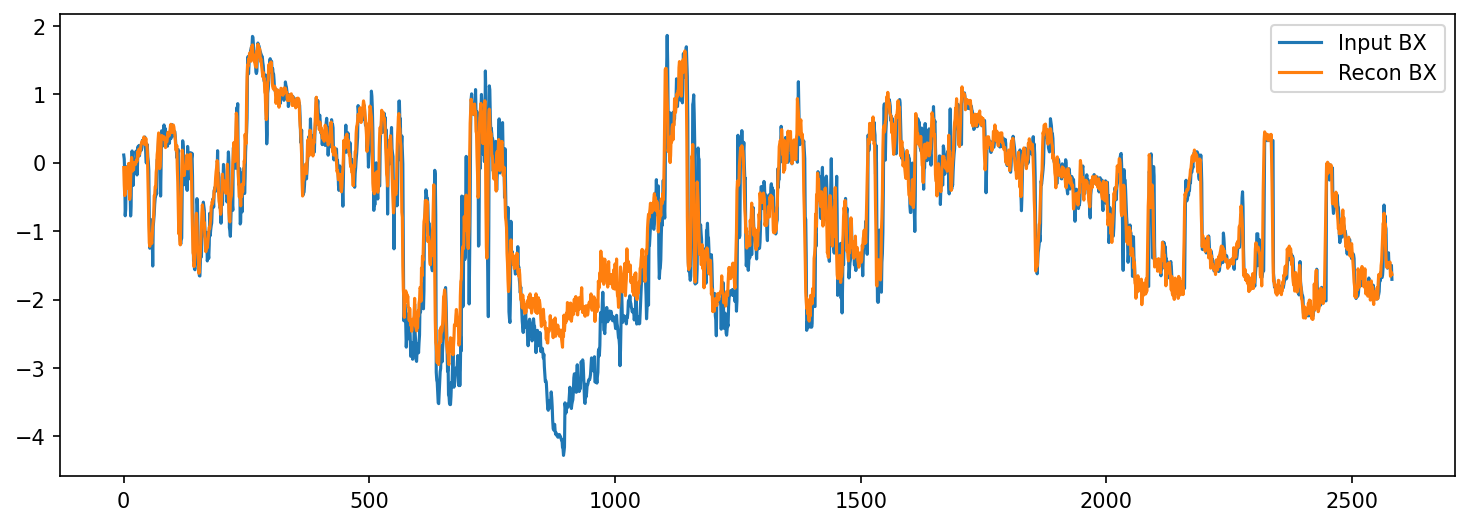

In [27]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(input_r[:,0], label='Input BX')
plt.plot(output_r[:,0], label='Recon BX')
plt.legend()
plt.show()

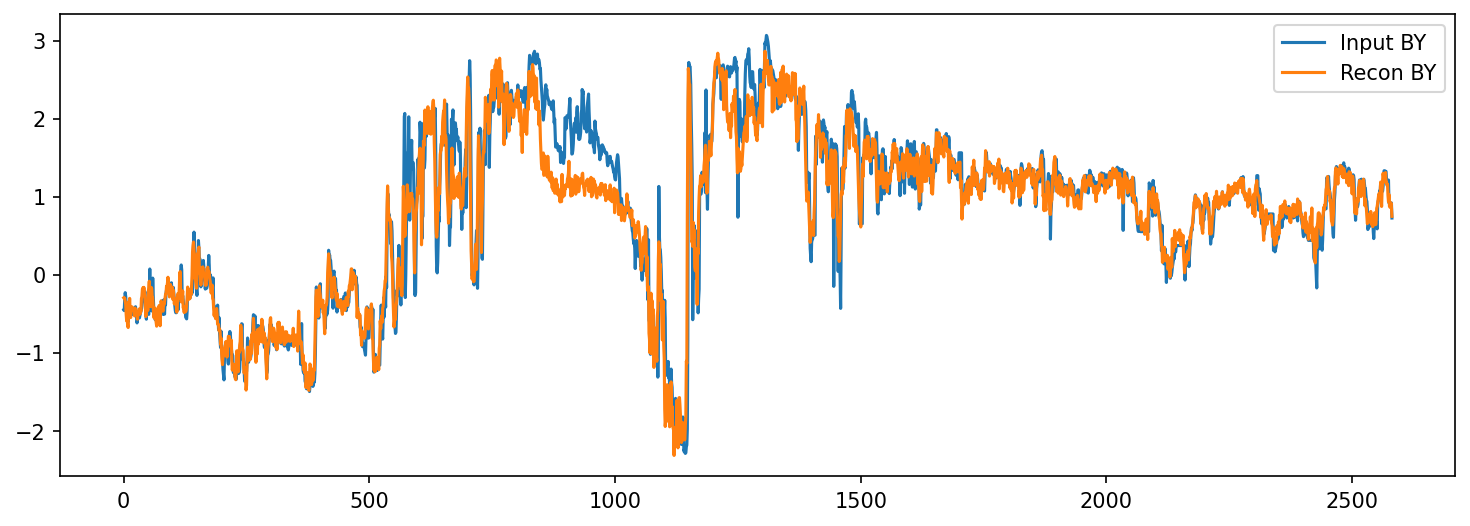

In [28]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(input_r[:,1], label='Input BY')
plt.plot(output_r[:,1], label='Recon BY')
plt.legend()
plt.show()

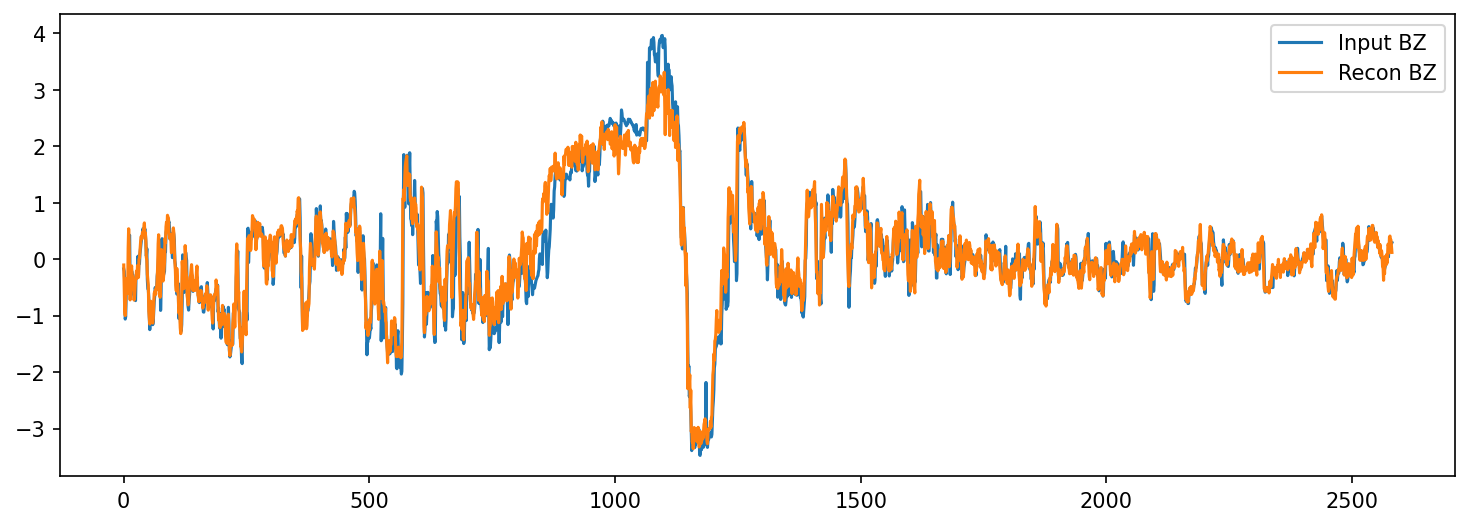

In [29]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(input_r[:,2], label='Input BZ')
plt.plot(output_r[:,2], label='Recon BZ')
plt.legend()
plt.show()

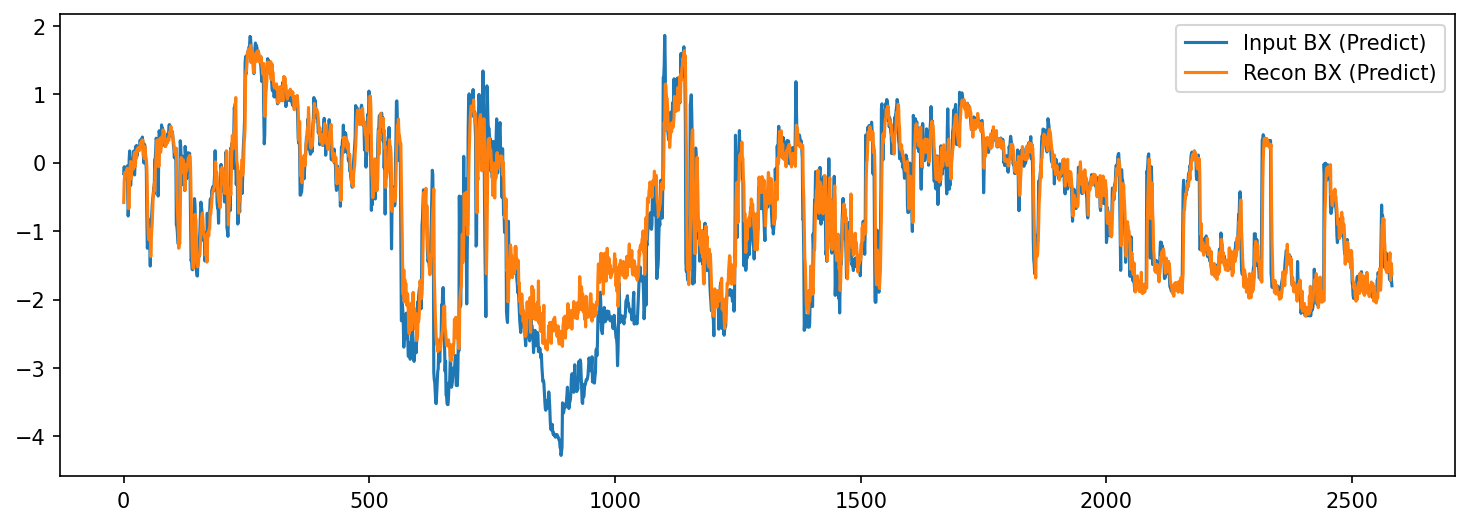

In [30]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(input_p[:,0], label='Input BX (Predict)')
plt.plot(output_p[:,0], label='Recon BX (Predict)')
plt.legend()
plt.show()

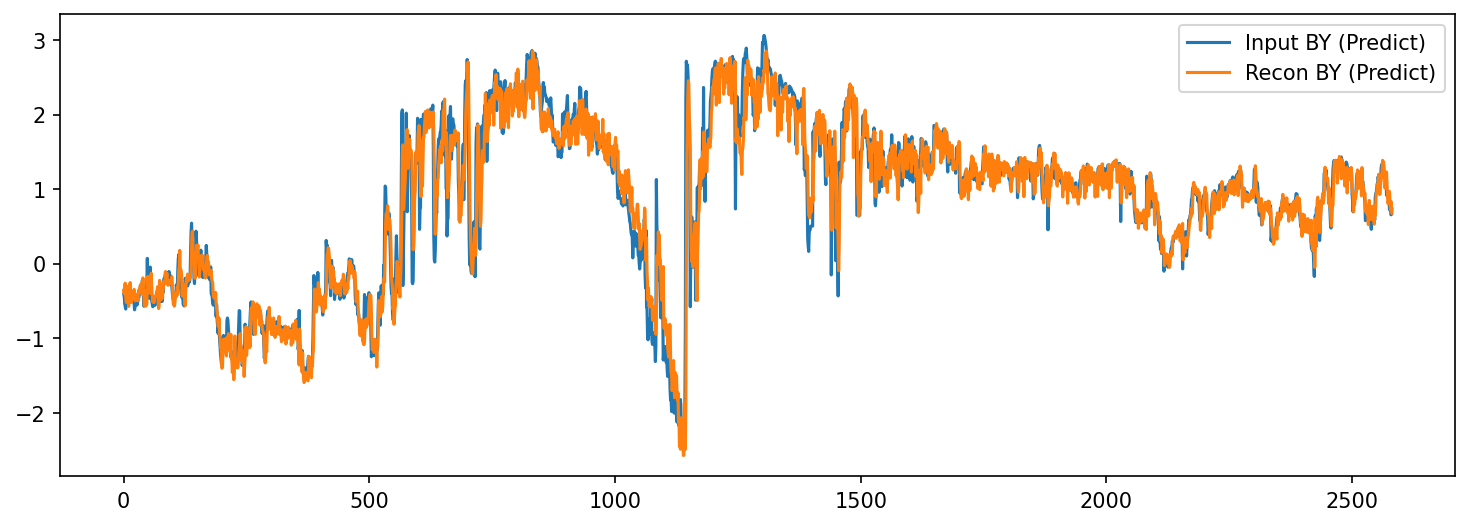

In [31]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(input_p[:,1], label='Input BY (Predict)')
plt.plot(output_p[:,1], label='Recon BY (Predict)')
plt.legend()
plt.show()

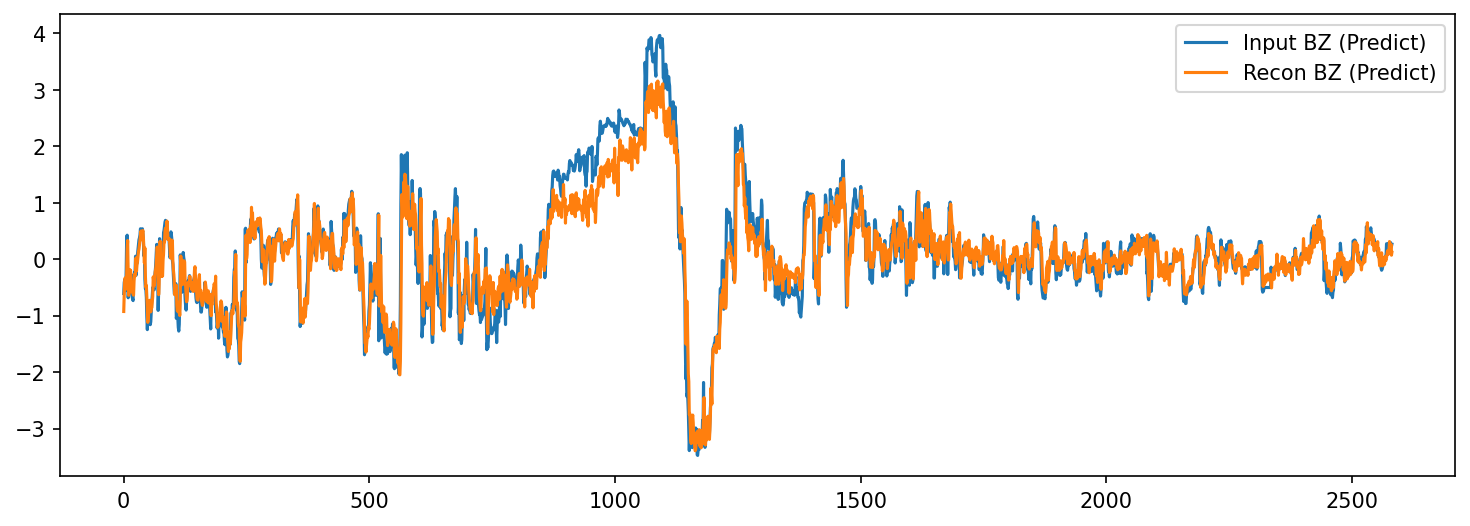

In [32]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(input_p[:,2], label='Input BZ (Predict)')
plt.plot(output_p[:,2], label='Recon BZ (Predict)')
plt.legend()
plt.show()